In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import datetime
import random
from collections import deque
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import tqdm
from tensorflow.keras.callbacks import TensorBoard
import os

In [0]:
# load data
df = pd.read_csv("/content/drive/My Drive/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv")

In [4]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Timestap is unix time. I will convert unix time to more readable data

In [0]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s")

In [6]:
# now Timestamp was converted 
df.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4363452,2020-04-21 23:56:00,6847.97,6856.35,6847.97,6856.35,0.125174,858.128697,6855.498790
4363453,2020-04-21 23:57:00,6850.23,6856.13,6850.23,6850.89,1.224777,8396.781459,6855.763449
4363454,2020-04-21 23:58:00,6846.50,6857.45,6846.02,6857.45,7.089168,48533.089069,6846.090966
4363455,2020-04-21 23:59:00,6854.18,6854.98,6854.18,6854.98,0.012231,83.831604,6854.195090
4363456,2020-04-22 00:00:00,6850.60,6850.60,6850.60,6850.60,0.014436,98.896906,6850.600000


In [7]:
df["Close"].isnull().sum()

1236977

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4363457 entries, 0 to 4363456
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   Timestamp          datetime64[ns]
 1   Open               float64       
 2   High               float64       
 3   Low                float64       
 4   Close              float64       
 5   Volume_(BTC)       float64       
 6   Volume_(Currency)  float64       
 7   Weighted_Price     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 266.3 MB


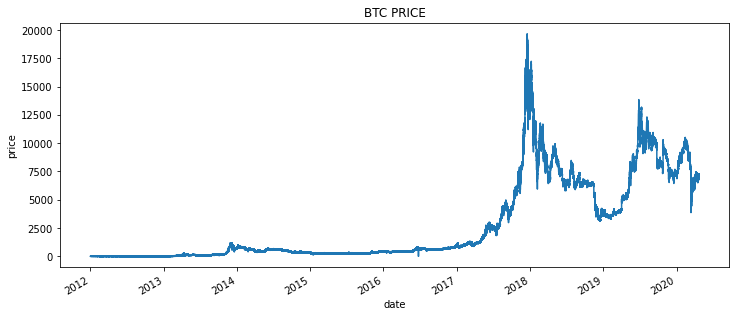

In [9]:
df.set_index("Timestamp")["Close"].plot(figsize=(12, 5), title="BTC PRICE")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

As some people know that price was increased on 2018

Let me check volume as well

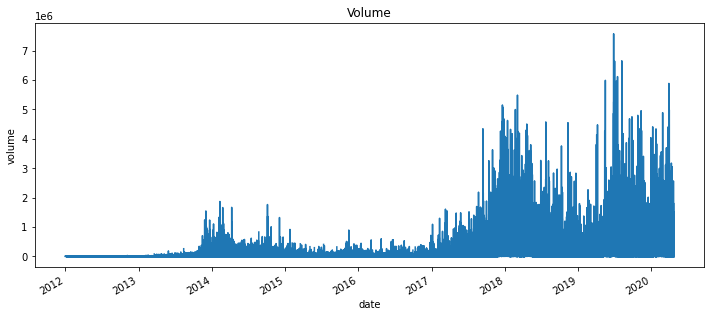

In [10]:
df.set_index("Timestamp")["Volume_(Currency)"].plot(figsize=(12, 5))
plt.title("Volume")
plt.xlabel("date")
plt.ylabel("volume")
plt.show()

As you see in the plot, Volume is increasing even now

In [0]:
# create date columns
df["year"] = df["Timestamp"].dt.year
df["month"] = df["Timestamp"].dt.month
df["day"] = df["Timestamp"].dt.day
df["day_of_week"] = df["Timestamp"].dt.dayofweek

In [12]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month,day,day_of_week
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,5
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,5
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,5
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011,12,31,5


fill in all of the nulls with the last known value.

In [0]:
df = df.fillna(method="ffill")

In [14]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month,day,day_of_week
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
1,2011-12-31 07:53:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
2,2011-12-31 07:54:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
3,2011-12-31 07:55:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
4,2011-12-31 07:56:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5


Check the price by week and month and hour

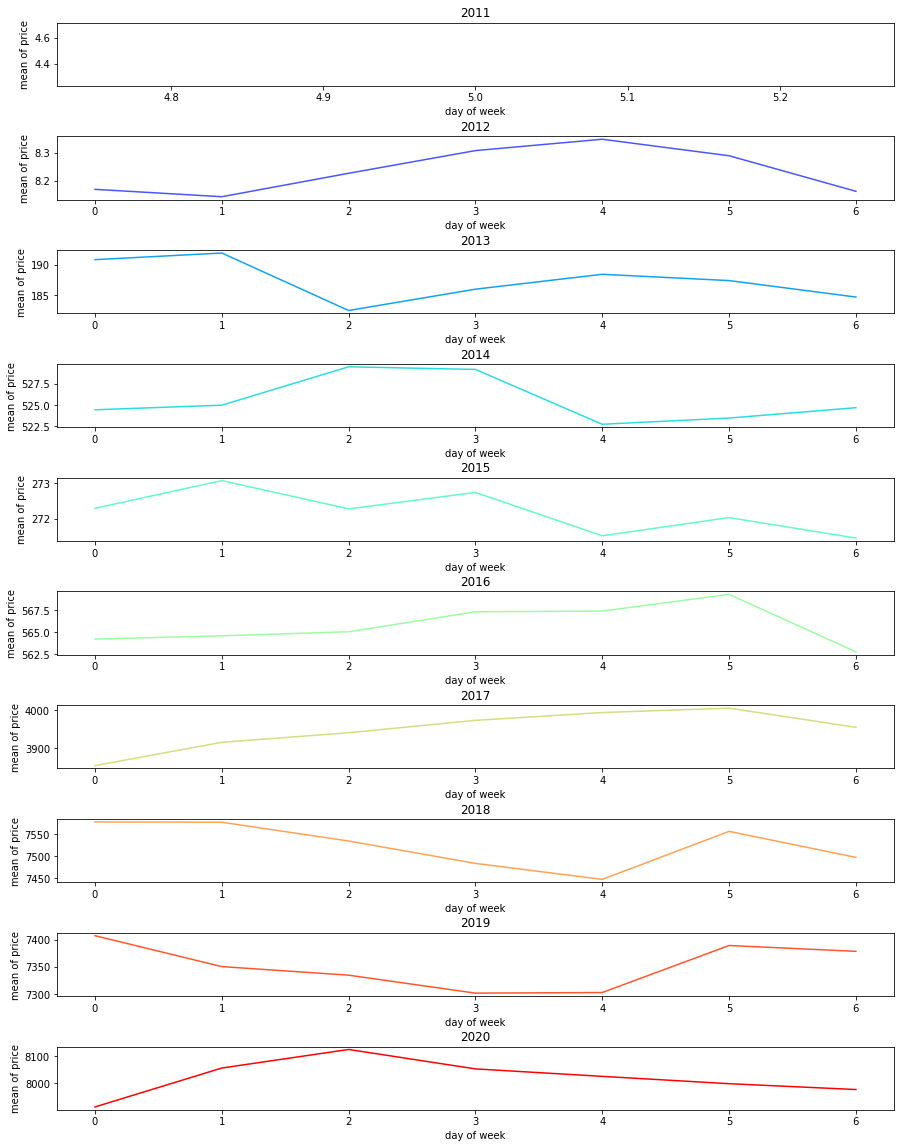

In [15]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.8)

year = df["year"].unique()

color=iter(cm.rainbow(np.linspace(0,1,len(year))))

# day of week(Monday=0, Sunday=6)
for i, value in enumerate(year):
    c = next(color)
    plt.subplot(len(year), 1, i+1)
    df[df["year"] == value].groupby("day_of_week").mean()["Close"].plot(c=c)
    plt.xlabel("day of week")
    plt.ylabel("mean of price")
    plt.title(value)

Interestingly since 2012, the trend was almost the same every 2 years

I will check price month as well

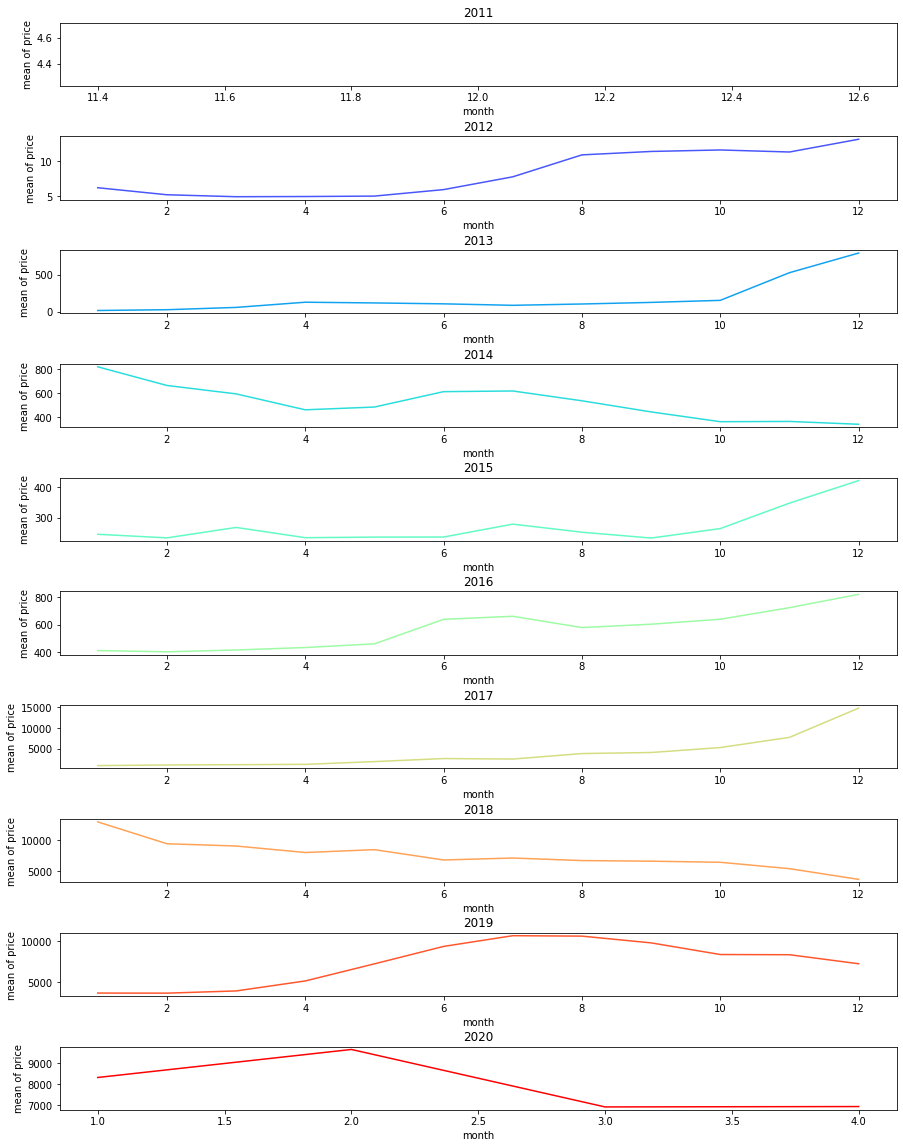

In [16]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=0.8)


year = df["year"].unique()

color=iter(cm.rainbow(np.linspace(0,1,len(year))))

# day of week(Monday=0, Sunday=6)
for i, value in enumerate(year):
    c = next(color)
    plt.subplot(len(year), 1, i+1)
    df[df["year"] == value].groupby("month").mean()["Close"].plot(c=c)
    plt.xlabel("month")
    plt.ylabel("mean of price")
    plt.title(value)

In [17]:
# drop duplicate date
df["Timestamp"] = df["Timestamp"].apply(lambda x: x.replace(minute=0, second=0))
df = df.drop_duplicates(subset="Timestamp", keep="last")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month,day,day_of_week
7,2011-12-31 07:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
67,2011-12-31 08:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
127,2011-12-31 09:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
187,2011-12-31 10:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
247,2011-12-31 11:00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5


In [18]:
# drop unnessesary colum
df = df.drop(["Timestamp"], axis=1)
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,year,month,day,day_of_week
7,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
67,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
127,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
187,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5
247,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011,12,31,5


In [19]:
df["future"] = df["Close"].shift(-24)

# remove last 7 days raw
df = df[:len(df)-24]

df[["Close", "future"]].head()


,Close,future
7,4.39,4.58
67,4.39,4.58
127,4.39,4.58
187,4.39,4.58
247,4.39,4.58


# Feature Selection of Lag Variables

In [0]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

y = df["future"]
x = df.drop("future", axis=1)

model = RFE(RandomForestRegressor(n_estimators=500, random_state=42), 4)
model = model.fit(x, y)

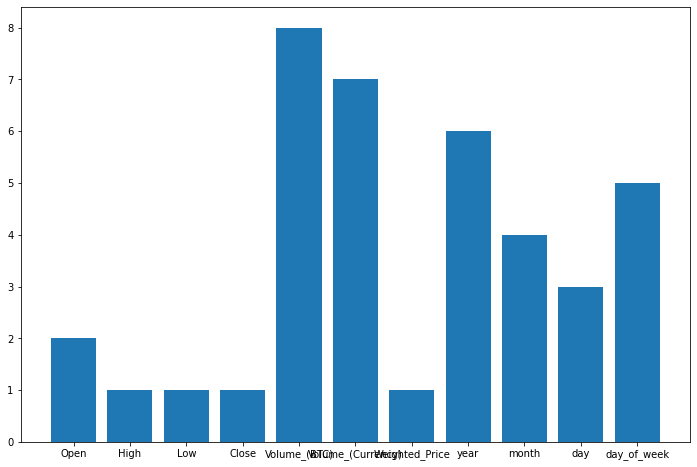

In [64]:
plt.figure(figsize=(12, 8))
columns_names = df.columns.values[0:-1]
ticks = [i for i in range(len(columns_names))]
pyplot.bar(ticks, model.ranking_)
pyplot.xticks(ticks, columns_names)
pyplot.show()

important feature are [volume_BTC, volume_currency, year, day_of_week]

In [20]:
# drop unnessesary columns
df = df.drop(["Open", "High", "Low", "Close", "Weighted_Price", "month", "day"], axis=1)
df.head()

,Volume_(BTC),Volume_(Currency),year,day_of_week,future
7,0.455581,2.0,2011,5,4.58
67,0.455581,2.0,2011,5,4.58
127,0.455581,2.0,2011,5,4.58
187,0.455581,2.0,2011,5,4.58
247,0.455581,2.0,2011,5,4.58


# Feature scaling

In [35]:
# split train and test
train, test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, shuffle=False)
# keep real price for prot
real_price = test["future"]

print("train_size:", len(train), "test_size:", len(test), "validation:", len(val))

train_size: 46529 test_size: 14541 validation: 11633


In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
X_train = sc.fit_transform(train.values)
X_val = sc.fit_transform(val.values)
X_test = sc.transform(test.values)

In [38]:
X_train.shape, X_val.shape, X_test.shape

((46529, 5), (11633, 5), (14541, 5))

In [0]:
# Define parameter
TIMESTEP = 1440
units = 64
batch_size = 64
epoch = 10
dropout_rate = 0.2
optimizer = "adam"
loss_function = 'mean_squared_error'
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3
)

In [0]:
def build_dataset(dataset):
  sequentioal_data = []
  target_data = []
  prev_days = deque(maxlen=TIMESTEP)

  for i in tqdm.tqdm(dataset):
    prev_days.append([x for x in i[:-1]])

    if len(prev_days) == TIMESTEP:
      sequentioal_data.append([np.array(prev_days), i[-1]])
  
  random.shuffle(sequentioal_data)

  x = []
  y = []

  for seq, target in sequentioal_data:
    x.append(seq)
    y.append(target)  

  return np.array(x), np.array(y)

In [40]:
X_train, Y_train = build_dataset(X_train)
X_test, Y_test = build_dataset(X_test)
X_val, Y_val = build_dataset(X_val)

100%|██████████| 11633/11633 [00:07<00:00, 1475.27it/s]


In [41]:
X_val.shape

(10194, 1440, 4)

In [74]:
# Tensorboard set
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-05-18 21:39:40--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.215.12.181, 34.193.189.199, 3.223.118.45, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.215.12.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  12.9MB/s    in 1.0s    

2020-05-18 21:39:42 (12.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = os.path.join("logs")
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('./ngrok http 6006 &')

In [42]:
#Run tensorboard
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://01658731.ngrok.io


In [0]:
tensorboard_callback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1,
                         write_images=True)

In [44]:
# create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

model = Sequential()

model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1:])))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(LSTM(units=units))
model.add(Dropout(dropout_rate))

model.add(Dense(units=1))

model.compile(optimizer=optimizer, loss=loss_function, metrics=['mae'])

model.fit(X_train, Y_train, epochs=epoch, batch_size=batch_size, validation_data=(X_val, Y_val), verbose=1, callbacks=[early_stop, tensorboard_callback])

Epoch 1/10
705/705 [==============================] - 215s 305ms/step - loss: 0.0201 - mae: 0.1071 - val_loss: 0.1220 - val_mae: 0.3000
Epoch 2/10
705/705 [==============================] - 215s 305ms/step - loss: 0.0077 - mae: 0.0642 - val_loss: 0.0866 - val_mae: 0.2576
Epoch 3/10
705/705 [==============================] - 214s 303ms/step - loss: 0.0047 - mae: 0.0499 - val_loss: 0.0863 - val_mae: 0.2480
Epoch 4/10
705/705 [==============================] - 212s 301ms/step - loss: 0.0039 - mae: 0.0447 - val_loss: 0.0672 - val_mae: 0.2074
Epoch 5/10
705/705 [==============================] - 212s 301ms/step - loss: 0.0035 - mae: 0.0417 - val_loss: 0.0472 - val_mae: 0.1679
Epoch 6/10
705/705 [==============================] - 210s 297ms/step - loss: 0.0027 - mae: 0.0363 - val_loss: 0.0077 - val_mae: 0.0608
Epoch 7/10
705/705 [==============================] - 209s 297ms/step - loss: 0.0038 - mae: 0.0410 - val_loss: 0.0140 - val_mae: 0.0963
Epoch 8/10
705/705 [============================

In [0]:
predicted_price = model.predict(X_test)

trainPredict_dataset_like = np.zeros(shape=(len(predicted_price), 5))
trainPredict_dataset_like[:,0] = predicted_price[:,0]
predicted_price = sc.inverse_transform(trainPredict_dataset_like)[:, 0]

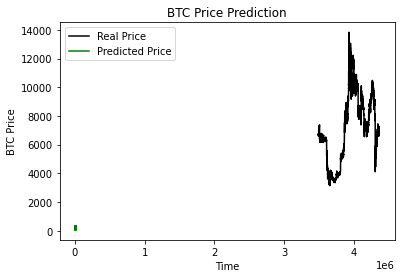

In [47]:
plt.plot(real_price, color = 'black', label = 'Real Price')
plt.plot(predicted_price, color = 'green', label = 'Predicted Price')
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [0]:
x, y = build_dataset(test.values)

In [366]:
x = x.reshape(-1,1)
x = sc.transform(x)

predicted_price = model.predict(x)

trainPredict_dataset_like = np.zeros(shape=(len(predicted_price), 11))
trainPredict_dataset_like[:,0] = predicted_price[:,0]
predicted_price = sc.inverse_transform(trainPredict_dataset_like)[:, 0]

ValueError: ignored

In [51]:
len(real_price), len(predicted_price)

(14541, 13102)